# [Part 1] - Data Analysis

# Introduction: Dataset Description

The dataset used in this project contains a set of measurements made by pressure sensors installed on several mattresses with the purpose of collecting in-bed posture data. The data collection was performed by *Pouyan et. al (2017)* and was documented on the article:  __[A Pressure Map Data set for In-bed Posture Classification](https://ieeexplore.ieee.org/document/7897206/)__. The dataset is publicly available and hosted by the [Physionet](https://physionet.org) databank [here](https://physionet.org/content/pmd/1.0.0/). 

The data was collected using Force Sensitive Application (FSA) pressure mapping mattresses with a sampling frequency of 1Hz. This pressure mat is light, thin, and flexible enough so it can cover the entire mattress. The data collection was divided into two phases (or experiments), as follows [(Pouyan et. al, 2017)](https://ieeexplore.ieee.org/document/7897206/):

*   **Experiment I:**  the sensors were uniformly distributed across a 32′′ × 64′′ mat with each sensor being almost one inch apart. 13 subjects participated in the experiment and performed eight standard bed postures (and some slight variations, summing up to 17 unique postures), which were summarized (labeled) as five common bed postures: _left_, _right_, _left fetus_, _right fetus_, and _supine_. Each subject performed each pose for at most two minutes.

*   **Experiment II:**  two pressure mats were used, a regular mattress and an air alternating mattress with sensors uniformly distributed across a 27′′ × 64′′ mat with each sensor being almost one inch apart. Eight subjects participated in this experiment and performed 29 postures that represent variations of the three common bed postures: _left_, _right_, and _supine_ (_left fetus_ and _right _fetus_ were labeled as _left_ and _right_, respectively). However, just one measurement per position is given. This measurement corresponds to the mean pressure value after 20 seconds of measurements.

  **Note:** subject three perform three additional postures but they were not documented. Hence, we performed a manual inspection before labeling them.

## Libraries and utilities

In [2]:
import os
import numpy as np
import cv2

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Exploratory Data Analysis

We now have a folder called __raw__ which corresponds to the raw dataset. The structure of this folder is the following

```
raw/
|
| --- experiment-i/
|         |--- S1/
|              |---- 1.txt
|              |---- 2.txt
|              ...
|          |--- S2/
|          ...
| --- experiment-ii/
|         |--- S1/
|              |---- Air_Mat/
|                       |--- Matrix_Air_B1.txt
|                       |--- Matrix_Air_B2.txt
|                       ...
|              |---- Sponge_Mat/
|                       |--- Matrix_Sponge_B1.txt
|                       |--- Matrix_Sponge_B2.txt
|                       ...
...

```

## Experiment I

### Inspection

In this experiment 13 subjects participated and performed 17 unique postures. Each posture is contained on a separate `.txt` file. 


In [3]:
exp_i_path = '../data/raw/experiment-i/'
# Read subjects
subjects_i = [file for file in os.listdir(exp_i_path) if os.path.isdir(os.path.join(exp_i_path, file))]
print(f"The subjects on the Experiment I are: {subjects_i}")

The subjects on the Experiment I are: ['S5', 'S2', 'S3', 'S4', 'S10', 'S11', 'S8', 'S1', 'S6', 'S7', 'S9', 'S13', 'S12']


Here we inspect one file:

In [60]:
exp_i_subject = 'S3'
exp_i_subject_pos = '8.txt'
test_read = np.loadtxt(os.path.join(exp_i_path, exp_i_subject, exp_i_subject_pos))
test_read.shape

(95, 2048)

Since the mat is composed of an arrangement of 32 x 64 (= 2048) sensors, it is correct to assume that the columns of the former `ndarray` correspond to the measurements of each sensor and the rows are the different measurements done.

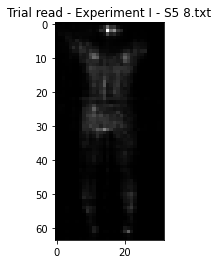

In [23]:
plt.title(f"Trial read - Experiment I - {exp_i_subject} {exp_i_subject_pos}")
test_image = test_read[10].reshape(64, 32)
test_image = test_image * 255 / 1000.
fig = plt.imshow(test_image, cmap='gray')

I also noticed that the first two measurements of all files do not display the data correctly, so I ignored them for the rest of the project.

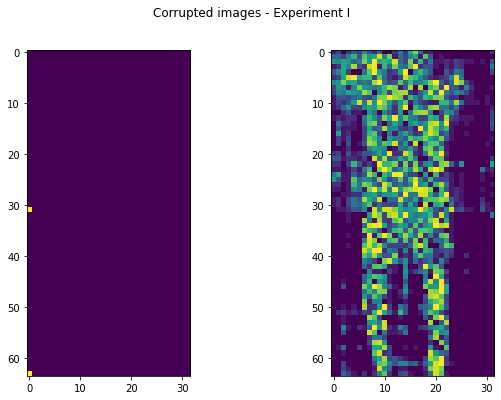

In [24]:
fig, axes = plt.subplots(figsize=(10,6), ncols=2)
fig.suptitle("Corrupted images - Experiment I")
for ii in range(2):
    ax = axes[ii]
    ax.imshow(test_read[ii,:].reshape(64,32))

Let's see one example from all 17 postures that one subject performs.

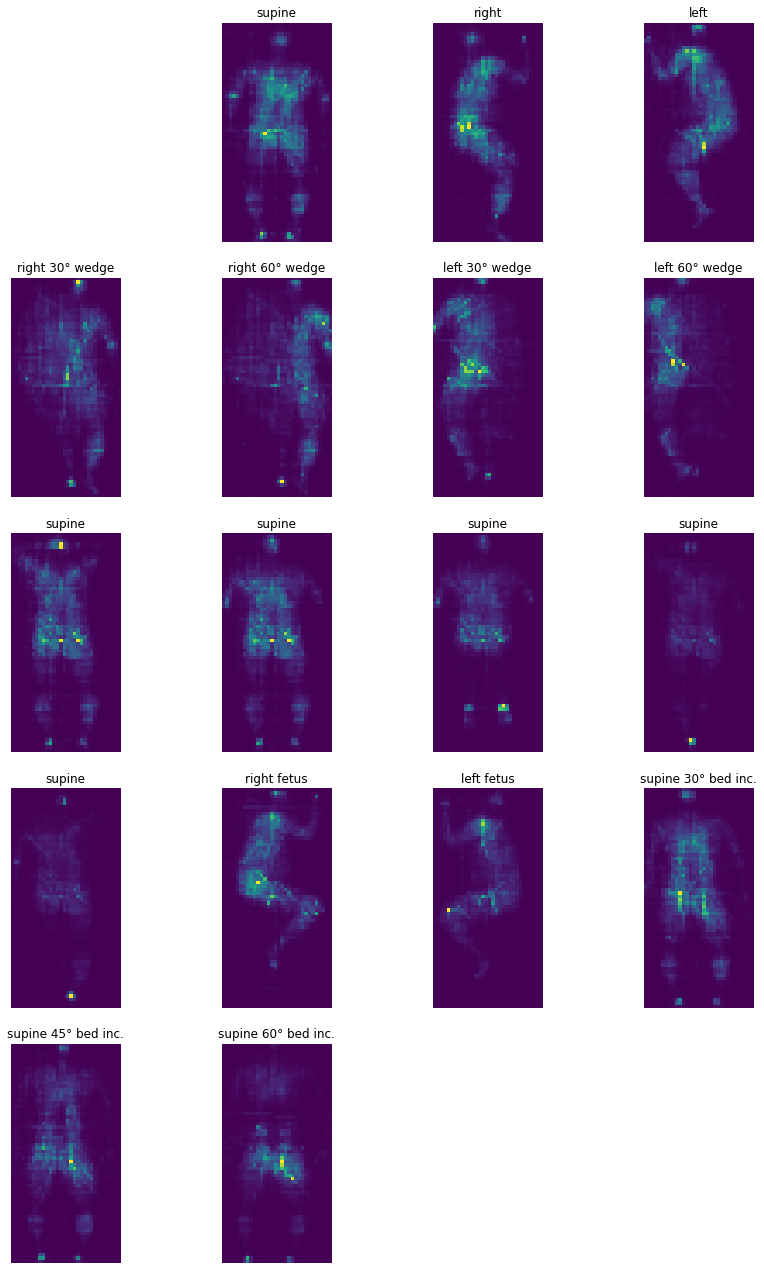

In [61]:
positions_i = [
    "justAPlaceholder",
    "supine",
    "right",
    "left",
    "right 30° wedge",
    "right 60° wedge",
    "left 30° wedge",
    "left 60° wedge",
    "supine",
    "supine",
    "supine",
    "supine",
    "supine",
    "right fetus",
    "left fetus",
    "supine 30° bed inc.",
    "supine 45° bed inc.",
    "supine 60° bed inc.",
]

fig, axes = plt.subplots(figsize=(12, 18), nrows=5, ncols=4, sharey=True)
axes = axes.ravel()
for idx, ax in enumerate(axes):
    if idx == 0 or idx >= len(positions_i):
        fig.delaxes(ax)
        continue
    exp_i_subject_pos = f"{idx}.txt"
    test_read = np.loadtxt(os.path.join(exp_i_path, exp_i_subject, exp_i_subject_pos))
    test_image = test_read[10].reshape(64, 32)
    test_image = test_image * 255 / np.max(test_image)
    ax.imshow(test_image)
    ax.set_title(positions_i[idx])
    ax.set_axis_off()
plt.tight_layout(2.0)

### Resizing

I wanted to increase the size of images. Here I am testing out all the possible resizing methods available in the `tf.image` API to see how they look and later on proceed with **area** method
since it does not affect the background while stretching the parts of image which already have non-zero values.

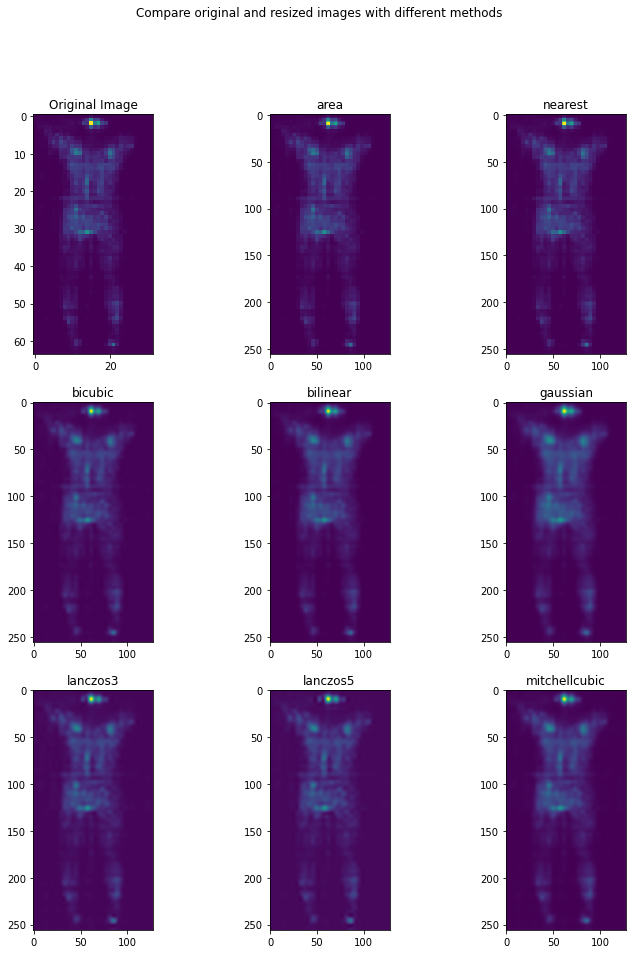

In [26]:
resize_methods = [
    'area',
    'nearest',
    'bicubic',
    'bilinear',
    'gaussian',
    'lanczos3',
    'lanczos5',
    'mitchellcubic',
]

fig, axes = plt.subplots(figsize=(12, 15), nrows=3, ncols=3)
axes = axes.ravel()
fig.suptitle("Compare original and resized images with different methods")
axes[0].imshow(test_image, )
axes[0].set_title('Original Image')
for idx, ax in enumerate(axes[1:]):
    method_name = resize_methods[idx]
    test_image_resized = tf.image.resize(
        np.expand_dims(test_image, axis=-1),
        [256, 128], method=method_name)
    test_image_resized = np.squeeze(test_image_resized)
    ax.imshow(test_image_resized)
    ax.set_title(method_name)

### Tensorflow Dataset

Here I load the dataset as a tf.data.Dataset object and analyze some examples to see if the labels and images correctly match each other.

In [ ]:
image_size = (256, 128)
path_classification_dataset = '/Users/orkhanbayramli/Desktop/the-last-castle/HDA/project-sleep-posture-monitoring/data/classification'

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path_classification_dataset,
    color_mode='grayscale',
    seed=1337,
    image_size=image_size,
)

Found 1089 files belonging to 3 classes.


2022-06-11 03:51:48.781624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
